In [21]:
import sys
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import re
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from pathlib import Path
from glob import glob
%precision 3
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor

# use my matplotlib style
# style_p = Path("Z:/Katsuya Shiratori/004_coding/python")
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))
import Lorentzian

## data upload

In [22]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

# all glass data
glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data = glass_data.drop(['corrcoef'], axis=1)

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

# define input and output
X_glass = glass_data.drop(['width', 'length', 'imax'], axis=1)
yw_glass = glass_data['width']
yl_glass = glass_data['length']

# define input and output
X_ito = ito_data.drop(['width', 'length', 'imax', 'ratio'], axis=1)
yw_ito = ito_data['width']
yl_ito = ito_data['length']

In [23]:
# define testing data from actual experiments
exp_glass_data = pd.read_csv(Path(p, '100323_ZJ_exp_glass_final.csv'))
exp_ito_data = pd.read_csv(Path(p, '100323_ZJ_exp_ito_final.csv'))
exp_ito_data = exp_ito_data.drop(47)
exp_ito_data = exp_ito_data.reset_index(drop=True)

# create the specific number of data
exp_glass_data = exp_glass_data.sample(50, random_state=4)
exp_ito_data = exp_ito_data.sample(50, random_state=4)

X_exp_glass = exp_glass_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
X_exp_glass['nsub'] = 1.52
yw_exp_glass = exp_glass_data['width']
yl_exp_glass = exp_glass_data['length']

X_exp_ito = exp_ito_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
X_exp_ito['nsub'] = 1.975
yw_exp_ito = exp_ito_data['width']
yl_exp_ito = exp_ito_data['length']

## data preprocess for the same distributions

In [4]:
# SPP all data in my paper
original_data = pd.read_csv(Path(p, 'New_SPP.csv'))
original_data['nsub'] = 1.52

# new glass simulated data
# glass_data = glass_data.drop(['ratio'], axis=1)
glass_data['nsub'] = 1.52

# new ITO simulated data
# ito_data = ito_data.drop(['ratio'], axis=1)
ito_data['nsub'] = 1.975

glass_comb_data = pd.concat([glass_data, original_data], axis=0)

# exclude the distribution with longer linwdith
glass_aranged_data = glass_comb_data[(glass_comb_data['width'] > ito_data['width'].min()) & (glass_comb_data['width'] < ito_data['width'].max()) 
                       & (glass_comb_data['length'] > ito_data['length'].min()) & (glass_comb_data['length'] < ito_data['length'].max())]

glass_aranged_data = glass_aranged_data.reset_index(drop=True)
glass_aranged_data['ratio'] = glass_aranged_data['length'] / glass_aranged_data['width']

combined_data = pd.concat([ito_data, glass_aranged_data], axis=0)

width mean+std: 29.01504972244251 +/- 2.0374904114785406
length mean+std: 85.26736772402855 +/- 10.132635913690464
width mean+std: 29.441281895504257 +/- 1.7842411542802916
length mean+std: 91.30991190765492 +/- 9.80495980250767


(60.000, 130.000)

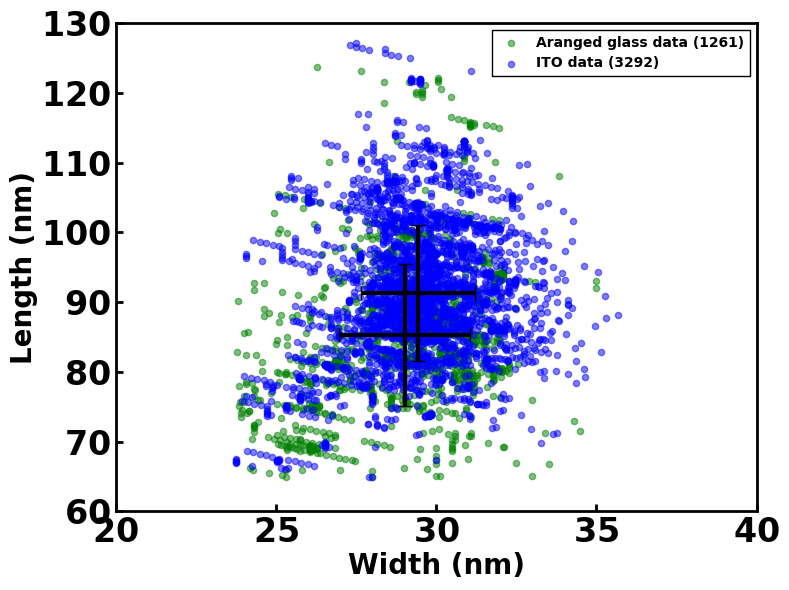

In [5]:
fig, ax = plt.subplots()

ax.scatter(glass_aranged_data['width'], glass_aranged_data['length'], c='g', s=20, alpha=.5, label=f'Aranged glass data ({glass_aranged_data.shape[0]})')
ax.scatter(ito_data['width'], ito_data['length'], c='b', s=20, alpha=.5, label=f'ITO data ({ito_data.shape[0]})')

print(f"width mean+std: {glass_aranged_data['width'].mean()} +/- {glass_aranged_data['width'].std()}")
print(f"length mean+std: {glass_aranged_data['length'].mean()} +/- {glass_aranged_data['length'].std()}")

print(f"width mean+std: {ito_data['width'].mean()} +/- {ito_data['width'].std()}")
print(f"length mean+std: {ito_data['length'].mean()} +/- {ito_data['length'].std()}")

ax.errorbar(ito_data['width'].mean(), ito_data['length'].mean(), 
            xerr=ito_data['width'].std(), yerr=ito_data['length'].std(),
            capsize=5, color='k')

ax.errorbar(glass_aranged_data['width'].mean(), glass_aranged_data['length'].mean(), 
            xerr=glass_aranged_data['width'].std(), yerr=glass_aranged_data['length'].std(),
            capsize=5, color='k')

# ax.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label='Error Bars')

ax.legend()

ax.set_xlabel('Width (nm)')
ax.set_ylabel('Length (nm)')

ax.set_xlim(20, 40)
ax.set_ylim(60, 130)

# title = f'''
# Glass Width: {round(glass_aranged_data['width'].mean(), 3)} \u00B1 {round(glass_aranged_data['width'].std(), 3)}
# Glass Length: {round(glass_aranged_data['length'].mean(), 3)} \u00B1 {round(glass_aranged_data['length'].std(), 3)}
# ITO Width: {round(ito_data['width'].mean(), 3)} \u00B1 {round(ito_data['width'].std(), 3)}
# ITO Length: {round(ito_data['length'].mean(), 3)} \u00B1 {round(ito_data['length'].std(), 3)}
# '''

# ax.set_title(title, fontsize=20)

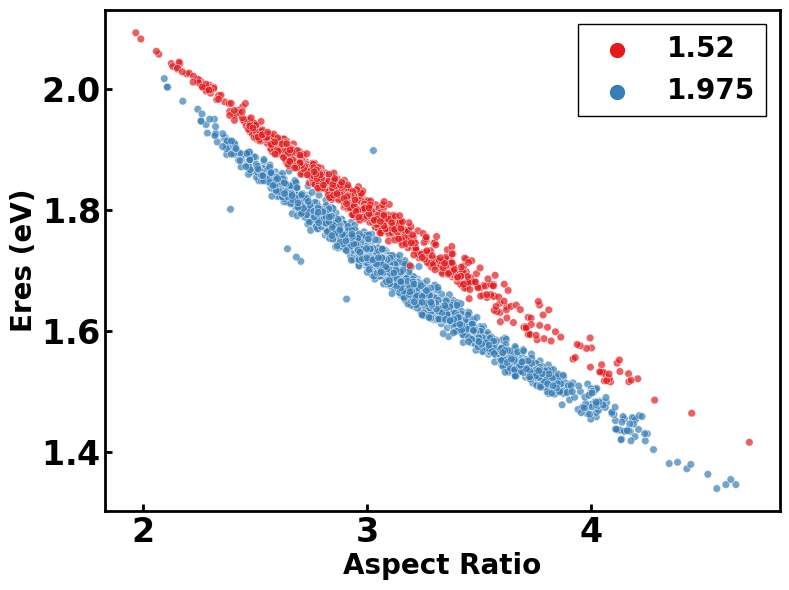

In [6]:
scatter = sns.scatterplot(data=combined_data, x='ratio', y='eres', hue='nsub', s=30, alpha=.7, palette="Set1")
scatter.set_xlabel("Aspect Ratio")
scatter.set_ylabel("Eres (eV)")
scatter.legend(fontsize=20)

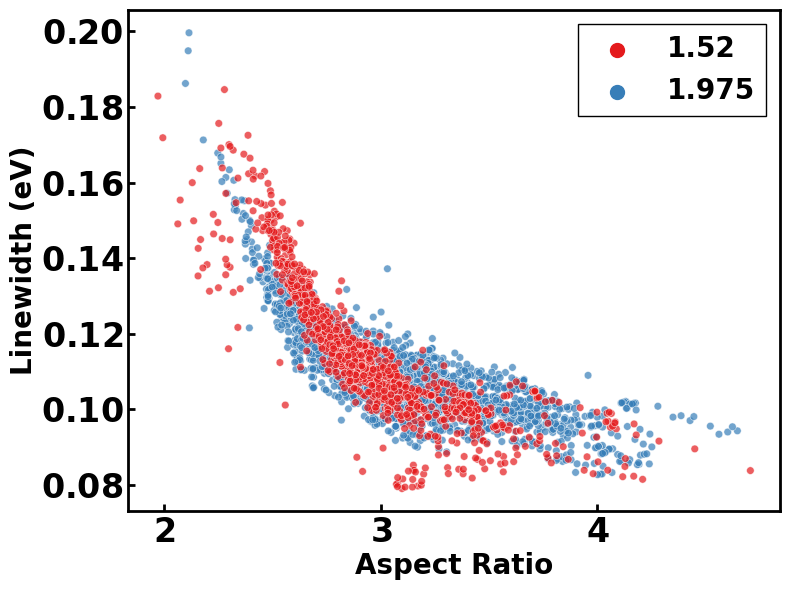

In [7]:
scatter = sns.scatterplot(data=combined_data, x='ratio', y='linewidth', hue='nsub', s=30, alpha=.7, palette="Set1")
scatter.set_xlabel("Aspect Ratio")
scatter.set_ylabel("Linewidth (eV)")
scatter.legend(fontsize=20)

## numerical correction

In [8]:
# further control the dataset so that all aspect ratio in glass can fall into the range of ITO's ratio
ito_ratio_min = ito_data['ratio'].min()
ito_ratio_max = ito_data['ratio'].max()

glass_aranged_data = glass_aranged_data[(glass_aranged_data['ratio'] > ito_ratio_min) & (glass_aranged_data['ratio'] < ito_ratio_max)]
glass_aranged_data = glass_aranged_data.reset_index(drop=True)

In [9]:
def calc_dif(idx, ito_data, glass_aranged_data):
    Eres_glass = glass_aranged_data['eres'][idx]
    Linewidth_glass = glass_aranged_data['linewidth'][idx]
    AR_glass = glass_aranged_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if (upper_min - AR_glass) > (AR_glass - lower_max):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    Linewidth_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['linewidth']
    dEres_IG = Eres_ito - Eres_glass
    dLinewidth_IG = Linewidth_ito - Linewidth_glass
    return dEres_IG, dLinewidth_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)

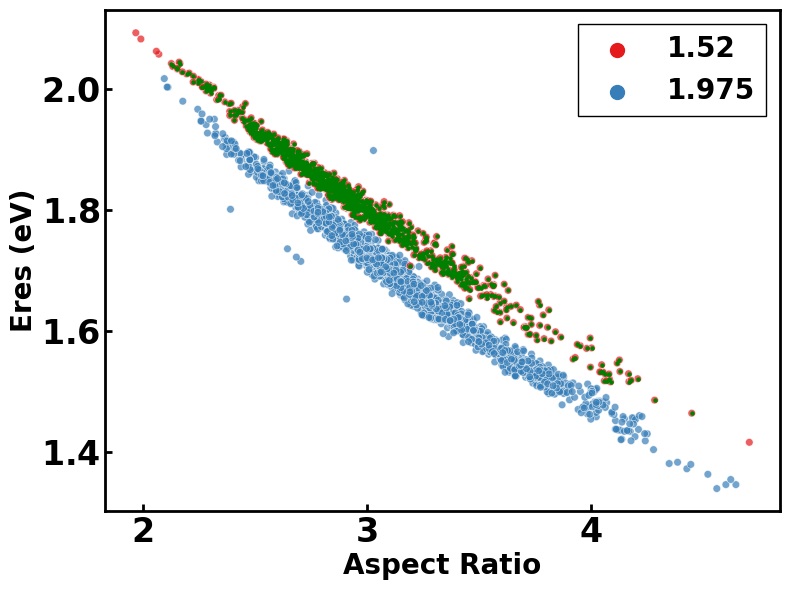

In [10]:
scatter = sns.scatterplot(data=combined_data, x='ratio', y='eres', hue='nsub', s=30, alpha=.7, palette="Set1")
plt.scatter(glass_aranged_data['ratio'], glass_aranged_data['eres'], s=5, c='g')
scatter.set_xlabel("Aspect Ratio")
scatter.set_ylabel("Eres (eV)")
scatter.legend(fontsize=20)

In [11]:
dnsub_IG = ito_data['nsub'][0] - glass_aranged_data['nsub'][0]
dEres_IG_list = []
dLinewidth_IG_list = []
for idx in range(glass_aranged_data.shape[0]):
    dEres_IG, dLinewidth_IG = calc_dif(idx, ito_data, glass_aranged_data)
    if (dEres_IG.shape == (1,)) and (dLinewidth_IG.shape == (1,)): 
        dEres_IG_list.append(dEres_IG.values)
        dLinewidth_IG_list.append(dLinewidth_IG.values)

In [12]:
print(len(dEres_IG_list), len(dLinewidth_IG_list))

1254 1254


Text(0, 0.5, 'Occurrences')

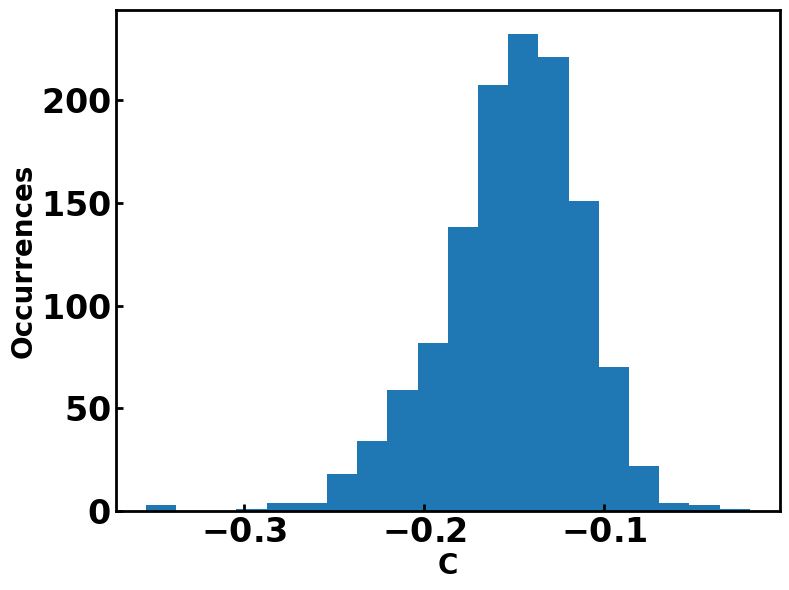

In [20]:
C_list = dEres_IG_list / dnsub_IG
plt.hist(C_list, bins=20)
plt.xlabel('C')
plt.ylabel('Occurrences')

In [14]:
dEres_IG_mean = calculate_mean(dEres_IG_list)
dLinewidth_IG_mean = calculate_mean(dLinewidth_IG_list)
C = dEres_IG_mean / dnsub_IG
D = dLinewidth_IG_mean / dnsub_IG
# print(C, D)

# TiO2
tio2_nsub = 2.358
al2o3_nsub = 1.762
glass_nsub = 1.52
ito_nsub = 1.975

ito_Eres = C*(ito_nsub - glass_nsub) + glass_aranged_data['eres']
ito_Linewidth = D*(ito_nsub - glass_nsub) + glass_aranged_data['linewidth']

tio2_Eres = C*(tio2_nsub - glass_nsub) + glass_aranged_data['eres']
tio2_Linewidth = D*(tio2_nsub - glass_nsub) + glass_aranged_data['linewidth']

al2o3_Eres = C*(al2o3_nsub - glass_nsub) + glass_aranged_data['eres']
al2o3_Linewidth = D*(al2o3_nsub - glass_nsub) + glass_aranged_data['linewidth']

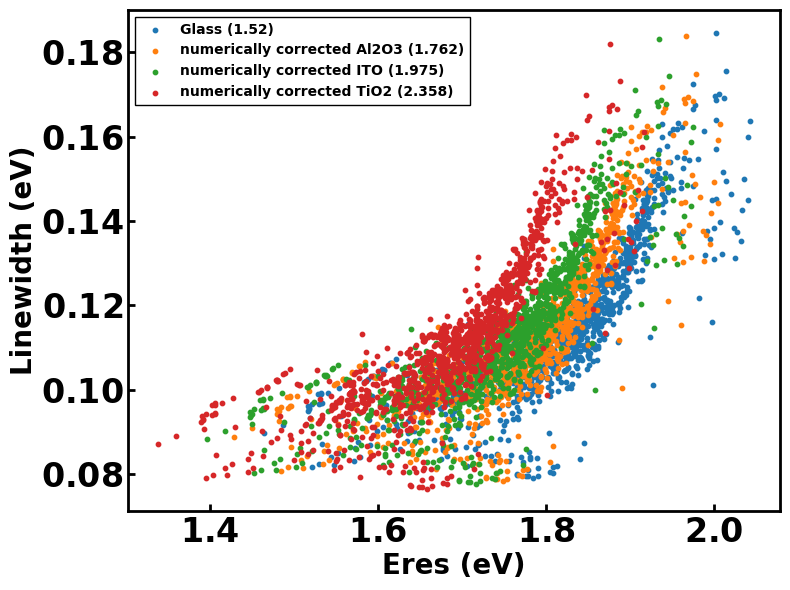

In [15]:
plt.scatter(glass_aranged_data['eres'], glass_aranged_data['linewidth'], s=10, label='Glass (1.52)')
plt.scatter(al2o3_Eres, al2o3_Linewidth, s=10, label='numerically corrected Al2O3 (1.762)')
plt.scatter(ito_Eres, ito_Linewidth, s=10, label='numerically corrected ITO (1.975)')
plt.scatter(tio2_Eres, tio2_Linewidth, s=10, label='numerically corrected TiO2 (2.358)')
plt.xlabel('Eres (eV)')
plt.ylabel('Linewidth (eV)')
plt.legend()

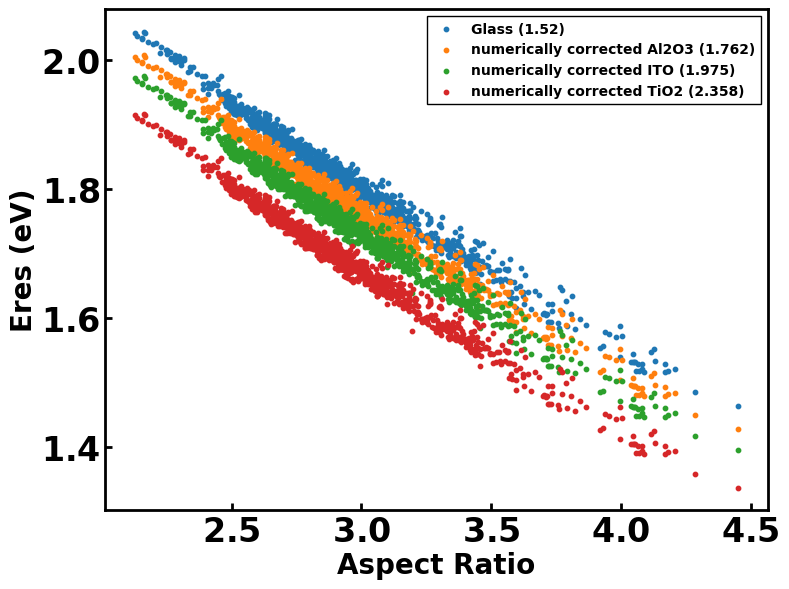

In [16]:
plt.scatter(glass_aranged_data['ratio'], glass_aranged_data['eres'], s=10, label='Glass (1.52)')
plt.scatter(glass_aranged_data['ratio'], al2o3_Eres, s=10, label='numerically corrected Al2O3 (1.762)')
plt.scatter(glass_aranged_data['ratio'], ito_Eres, s=10, label='numerically corrected ITO (1.975)')
plt.scatter(glass_aranged_data['ratio'], tio2_Eres, s=10, label='numerically corrected TiO2 (2.358)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Eres (eV)')
plt.legend()

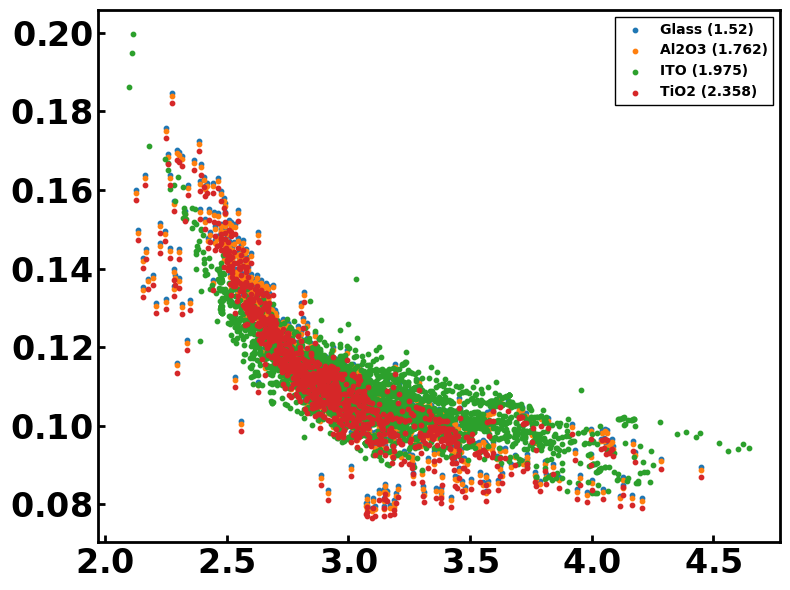

In [18]:
plt.scatter(glass_aranged_data['ratio'], glass_aranged_data['linewidth'], s=10, label='Glass (1.52)')
plt.scatter(glass_aranged_data['ratio'], al2o3_Linewidth, s=10, label='Al2O3 (1.762)')
plt.scatter(ito_data['ratio'], ito_data['linewidth'], s=10, label='ITO (1.975)')
plt.scatter(glass_aranged_data['ratio'], tio2_Linewidth, s=10, label='TiO2 (2.358)')
plt.legend()

0.19934052971684083 0.16955963721938797


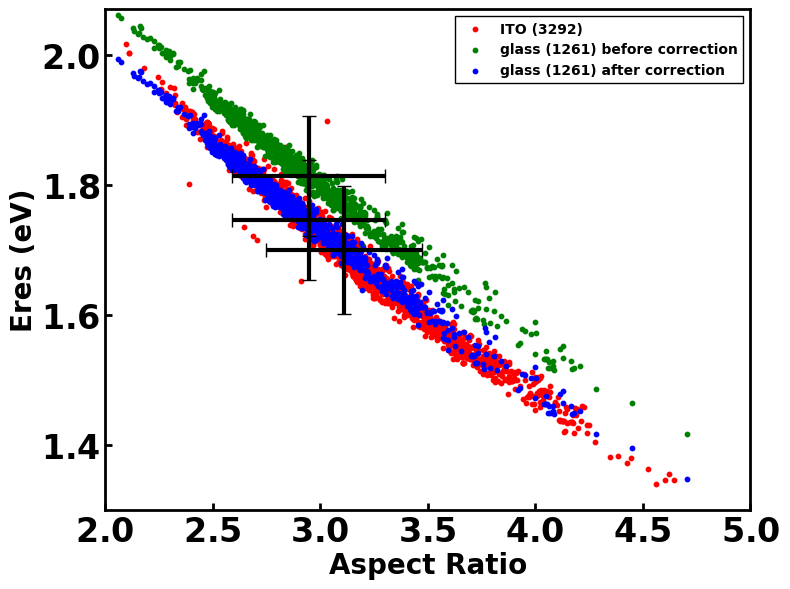

In [205]:
# numerical correction

ito_ratio_mean = ito_data['ratio'].mean()
ito_eres_mean = ito_data['eres'].mean()
glass_ratio_mean = glass_aranged_data['ratio'].mean()
glass_eres_mean = glass_aranged_data['eres'].mean()
corr_glass_ratio_mean = glass_aranged_data['ratio'].mean()
corr_glass_eres_mean = ito_Eres.mean()

dist_before_corr = np.sqrt(abs(glass_ratio_mean-ito_ratio_mean)**2 + abs(glass_eres_mean-ito_eres_mean)**2)
dist_after_corr = np.sqrt(abs(corr_glass_ratio_mean-ito_ratio_mean)**2 + abs(corr_glass_eres_mean-ito_eres_mean)**2)

print(dist_before_corr, dist_after_corr)

fig, ax = plt.subplots()

ax.scatter(ito_data['ratio'], ito_data['eres'], c='r', s=10, label=f'ITO ({ito_data.shape[0]})')
ax.scatter(glass_aranged_data['ratio'], glass_aranged_data['eres'], c='g', s=10, label=f'glass ({glass_aranged_data.shape[0]}) before correction')
ax.scatter(glass_aranged_data['ratio'], ito_Eres, c='b', s=10, label=f'glass ({glass_aranged_data.shape[0]}) after correction')

ax.errorbar(ito_data['ratio'].mean(), ito_data['eres'].mean(), 
            xerr=ito_data['ratio'].std(), yerr=ito_data['eres'].std(),
            capsize=5, color='k')

ax.errorbar(glass_aranged_data['ratio'].mean(), glass_aranged_data['eres'].mean(), 
            xerr=glass_aranged_data['ratio'].std(), yerr=glass_aranged_data['eres'].std(),
            capsize=5, color='k')

ax.errorbar(glass_aranged_data['ratio'].mean(), ito_Eres.mean(), 
            xerr=glass_aranged_data['ratio'].std(), yerr=ito_Eres.std(),
            capsize=5, color='k')

ax.set_xlabel('Aspect Ratio')
ax.set_ylabel('Eres (eV)')
ax.set_xlim([2.0, 5.0])
ax.set_ylim([1.3, 2.07])
ax.legend()

0.19934052971684083 0.17459694621490837


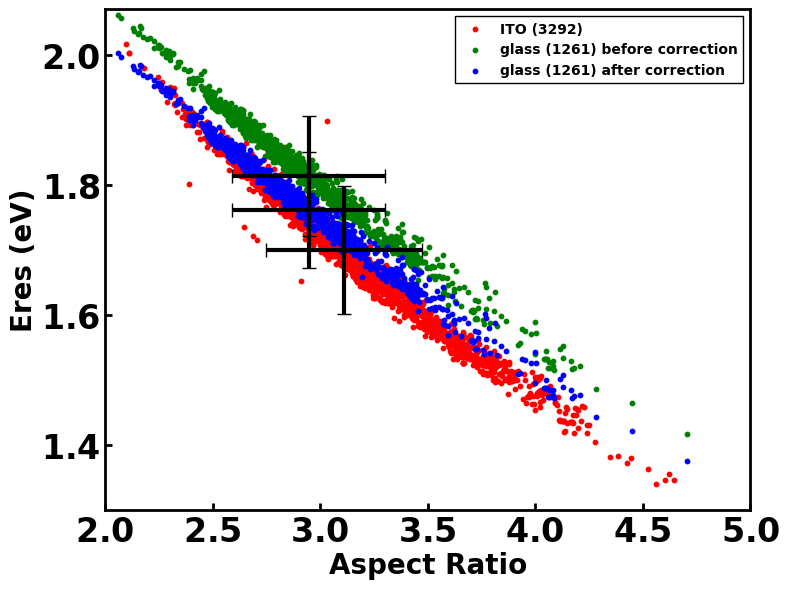

In [206]:
# empirical method
glass_corrected_data = glass_aranged_data['eres']*0.971
corr_glass_ratio_mean = glass_aranged_data['ratio'].mean()
corr_glass_eres_mean = glass_corrected_data.mean()

dist_before_corr = np.sqrt(abs(glass_ratio_mean-ito_ratio_mean)**2 + abs(glass_eres_mean-ito_eres_mean)**2)
dist_after_corr = np.sqrt(abs(corr_glass_ratio_mean-ito_ratio_mean)**2 + abs(corr_glass_eres_mean-ito_eres_mean)**2)


print(dist_before_corr, dist_after_corr)

fig, ax = plt.subplots()

ax.scatter(ito_data['ratio'], ito_data['eres'], c='r', s=10, label=f'ITO ({ito_data.shape[0]})')
ax.scatter(glass_aranged_data['ratio'], glass_aranged_data['eres'], c='g', s=10, label=f'glass ({glass_aranged_data.shape[0]}) before correction')
ax.scatter(glass_aranged_data['ratio'], glass_corrected_data, c='b', s=10, label=f'glass ({glass_aranged_data.shape[0]}) after correction')

ax.errorbar(ito_data['ratio'].mean(), ito_data['eres'].mean(), 
            xerr=ito_data['ratio'].std(), yerr=ito_data['eres'].std(),
            capsize=5, color='k')

ax.errorbar(glass_aranged_data['ratio'].mean(), glass_aranged_data['eres'].mean(), 
            xerr=glass_aranged_data['ratio'].std(), yerr=glass_aranged_data['eres'].std(),
            capsize=5, color='k')

ax.errorbar(glass_aranged_data['ratio'].mean(), glass_corrected_data.mean(), 
            xerr=glass_aranged_data['ratio'].std(), yerr=glass_corrected_data.std(),
            capsize=5, color='k')

ax.set_xlabel('Aspect Ratio')
ax.set_ylabel('Eres (eV)')
ax.set_xlim([2.0, 5.0])
ax.set_ylim([1.3, 2.07])
ax.legend()

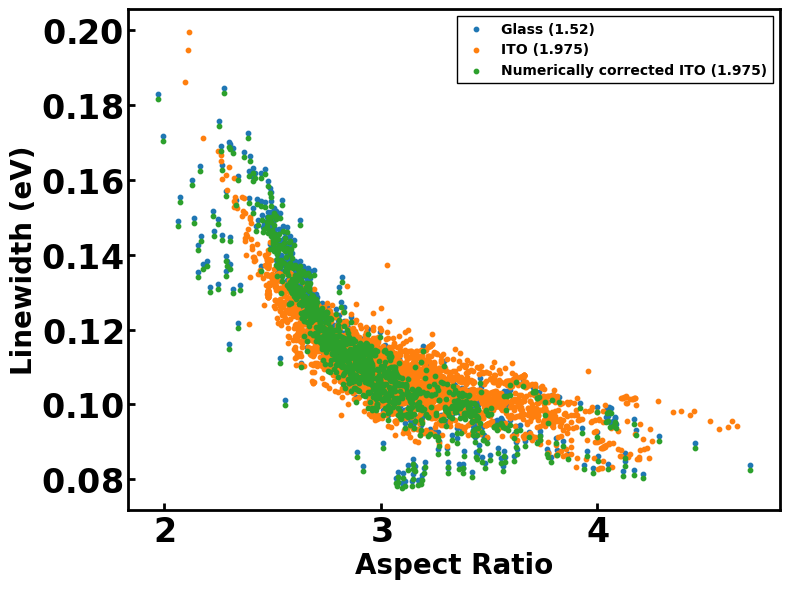

In [158]:
plt.scatter(glass_aranged_data['ratio'], glass_aranged_data['linewidth'], s=10, label='Glass (1.52)')
plt.scatter(ito_data['ratio'], ito_data['linewidth'], s=10, label='ITO (1.975)')
plt.scatter(glass_aranged_data['ratio'], ito_Linewidth, s=10, label='Numerically corrected ITO (1.975)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Linewidth (eV)')
plt.legend()

## TiO2 simulated by Stephen 

In [19]:
tio2_data = pd.read_csv('040424_tio2_data.csv')
tio2_data['ratio'] = tio2_data['length'] / tio2_data['width']
tio2_data.head()

,eres,linewidth,imax,width,length,R2,ratio
0,1.623329,0.073606,6.687991e-16,16.0,56.0,0.999838,3.5000
1,1.607552,0.074397,6.996053e-16,16.0,57.0,0.999831,3.5625
2,1.594032,0.075078,7.201313e-16,16.0,58.0,0.999822,3.6250
3,1.578523,0.075908,7.483116e-16,16.0,59.0,0.999810,3.6875
4,1.565403,0.076591,7.678674e-16,16.0,60.0,0.999800,3.7500


In [20]:
tio2_data = tio2_data[(tio2_data['width'] > ito_data['width'].min()) & (tio2_data['width'] < ito_data['width'].max()) 
                       & (tio2_data['length'] > ito_data['length'].min()) & (tio2_data['length'] < ito_data['length'].max())]

tio2_data = tio2_data.reset_index(drop=True)

(50.000, 130.000)

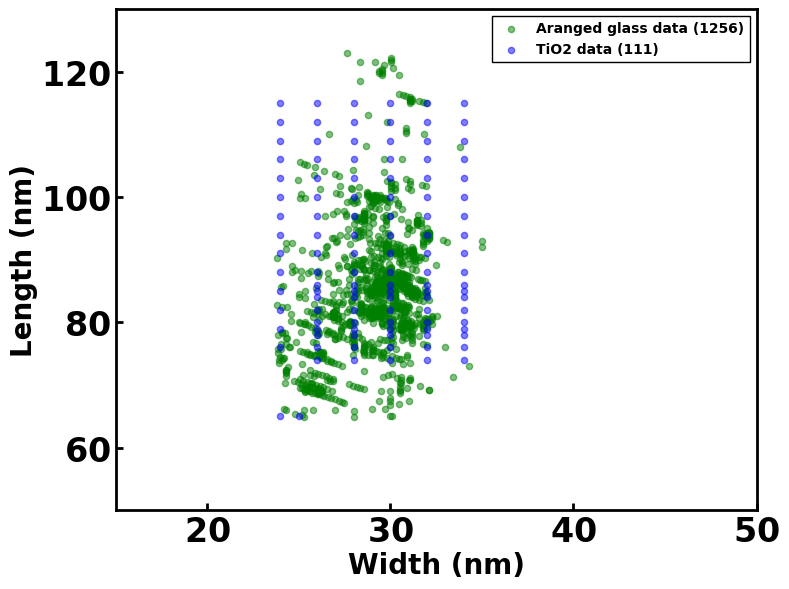

In [21]:
fig, ax = plt.subplots()

ax.scatter(glass_aranged_data['width'], glass_aranged_data['length'], c='g', s=20, alpha=.5, label=f'Aranged glass data ({glass_aranged_data.shape[0]})')
ax.scatter(tio2_data['width'], tio2_data['length'], c='b', s=20, alpha=.5, label=f'TiO2 data ({tio2_data.shape[0]})')

# ax.scatter(ito_data['width'], ito_data['length'], c='b', s=20, alpha=.5, label=f'ITO data ({ito_data.shape[0]})')

# print(f"width mean+std: {glass_aranged_data['width'].mean()} +/- {glass_aranged_data['width'].std()}")
# print(f"length mean+std: {glass_aranged_data['length'].mean()} +/- {glass_aranged_data['length'].std()}")

# print(f"width mean+std: {ito_data['width'].mean()} +/- {ito_data['width'].std()}")
# print(f"length mean+std: {ito_data['length'].mean()} +/- {ito_data['length'].std()}")

# ax.errorbar(ito_data['width'].mean(), ito_data['length'].mean(), 
#             xerr=ito_data['width'].std(), yerr=ito_data['length'].std(),
#             capsize=5, color='k')

# ax.errorbar(glass_aranged_data['width'].mean(), glass_aranged_data['length'].mean(), 
#             xerr=glass_aranged_data['width'].std(), yerr=glass_aranged_data['length'].std(),
#             capsize=5, color='k')

ax.set_xlabel('Width (nm)')
ax.set_ylabel('Length (nm)')
ax.legend()

ax.set_xlim(15, 50)
ax.set_ylim(50, 130)

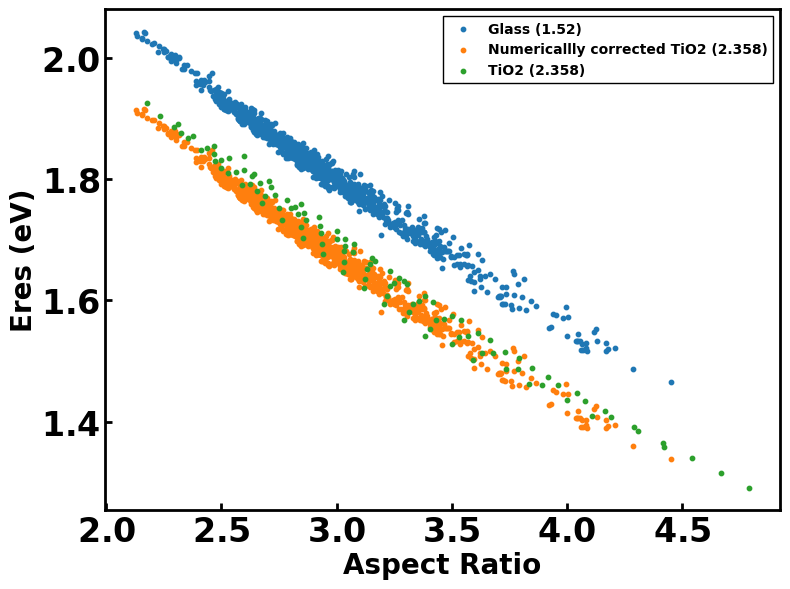

In [22]:
# add TiO2 simulated data from Stephen 
plt.scatter(glass_aranged_data['ratio'], glass_aranged_data['eres'], s=10, label='Glass (1.52)')
plt.scatter(glass_aranged_data['ratio'], tio2_Eres, s=10, label='Numericallly corrected TiO2 (2.358)')
plt.scatter(tio2_data['ratio'], tio2_data['eres'], s=10, label='TiO2 (2.358)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Eres (eV)')
plt.legend()

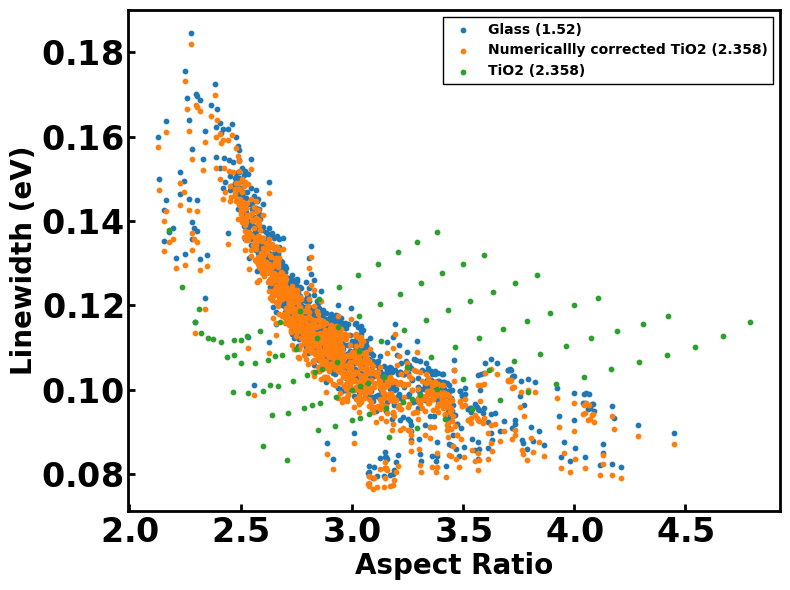

In [23]:
# add TiO2 simulated data from Stephen 
plt.scatter(glass_aranged_data['ratio'], glass_aranged_data['linewidth'], s=10, label='Glass (1.52)')
plt.scatter(glass_aranged_data['ratio'], tio2_Linewidth, s=10, label='Numericallly corrected TiO2 (2.358)')
plt.scatter(tio2_data['ratio'], tio2_data['linewidth'], s=10, label='TiO2 (2.358)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Linewidth (eV)')
plt.legend()

## ITO simulated by Stephen

In [24]:
ito_data2 = pd.read_csv('040524_ito_data.csv')
ito_data2['ratio'] = ito_data2['length'] / ito_data2['width']
ito_data2.head()

,eres,linewidth,imax,width,length,R2,ratio
0,1.674264,0.069511,7.585166e-16,16.0,56.0,0.999844,3.5000
1,1.660211,0.069764,8.037022e-16,16.0,57.0,0.999849,3.5625
2,1.647402,0.070153,8.327321e-16,16.0,58.0,0.999847,3.6250
3,1.633577,0.070649,8.734676e-16,16.0,59.0,0.999843,3.6875
4,1.621153,0.071149,9.005128e-16,16.0,60.0,0.999834,3.7500


In [25]:
# exclude the distribution with longer linwdith
ito_data2 = ito_data2[(ito_data2['width'] > ito_data['width'].min()) & (ito_data2['width'] < ito_data['width'].max()) 
                       & (ito_data2['length'] > ito_data['length'].min()) & (ito_data2['length'] < ito_data['length'].max())]

ito_data2 = ito_data2.reset_index(drop=True)

(50.000, 130.000)

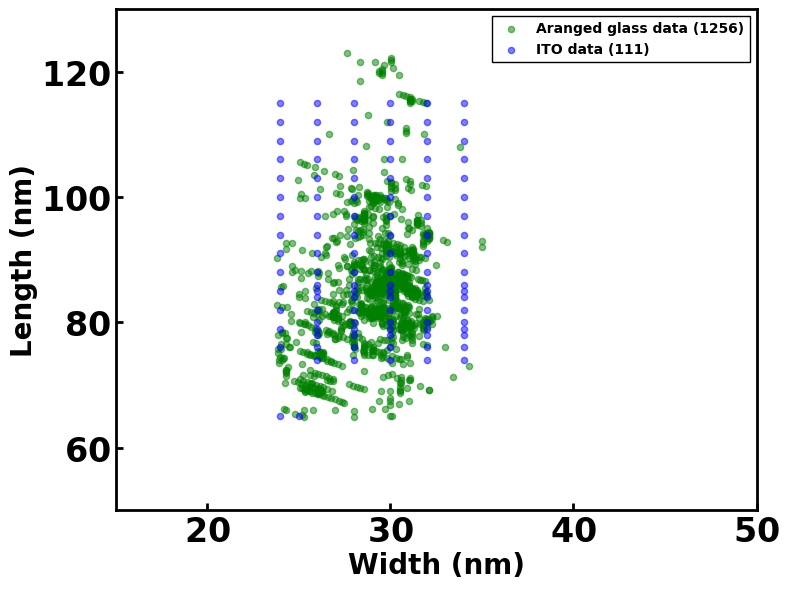

In [26]:
fig, ax = plt.subplots()

ax.scatter(glass_aranged_data['width'], glass_aranged_data['length'], c='g', s=20, alpha=.5, label=f'Aranged glass data ({glass_aranged_data.shape[0]})')
ax.scatter(ito_data2['width'], ito_data2['length'], c='b', s=20, alpha=.5, label=f'ITO data ({ito_data2.shape[0]})')

ax.set_xlabel('Width (nm)')
ax.set_ylabel('Length (nm)')
ax.legend()

ax.set_xlim(15, 50)
ax.set_ylim(50, 130)

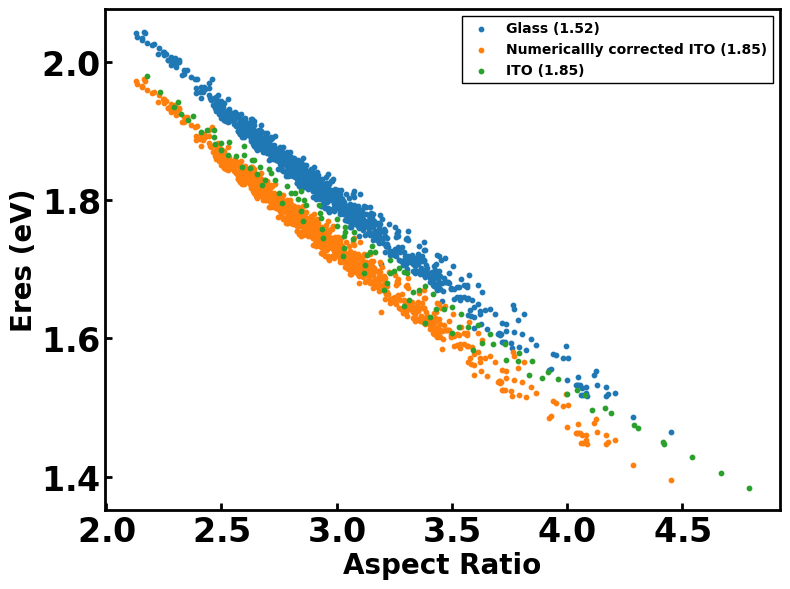

In [27]:
# add ITO simulated data from Stephen 
plt.scatter(glass_aranged_data['ratio'], glass_aranged_data['eres'], s=10, label='Glass (1.52)')
plt.scatter(glass_aranged_data['ratio'], ito_Eres, s=10, label='Numericallly corrected ITO (1.85)')
plt.scatter(ito_data2['ratio'], ito_data2['eres'], s=10, label='ITO (1.85)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Eres (eV)')
plt.legend()

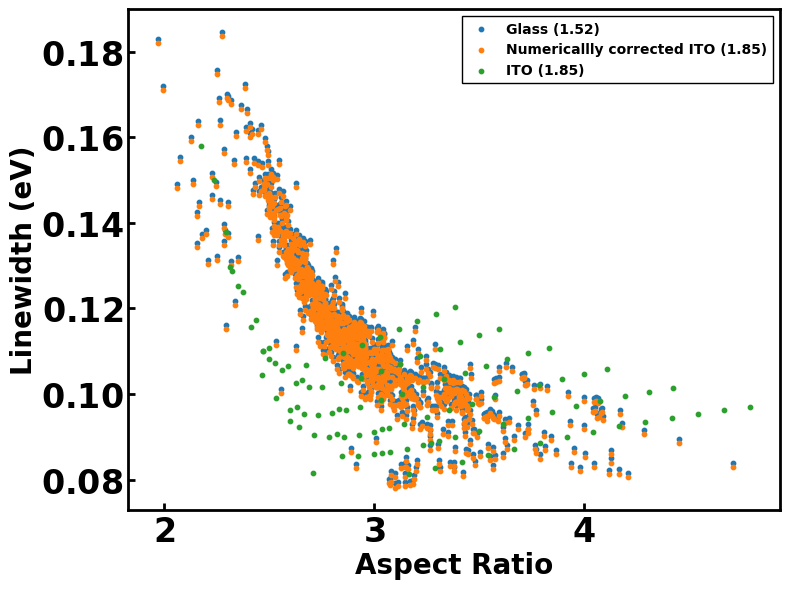

In [149]:
# add ITO simulated data from Stephen 
plt.scatter(glass_aranged_data['ratio'], glass_aranged_data['linewidth'], s=10, label='Glass (1.52)')
plt.scatter(glass_aranged_data['ratio'], ito_Linewidth, s=10, label='Numericallly corrected ITO (1.85)')
plt.scatter(ito_data2['ratio'], ito_data2['linewidth'], s=10, label='ITO (1.85)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Linewidth (eV)')
plt.legend()

## AuNRs uniqueness: one-to-many problem

In [26]:
# calculate ratio, surface area, and volume
glass_data['ratio'] = glass_data['length'] / glass_data['width']
glass_data['surface_area'] = np.pi * glass_data['width'] * glass_data['length']
glass_data['volume'] = np.pi*(glass_data['width']**2)*glass_data['length']/4 - np.pi*(glass_data['width']**3)/12
ito_data['surface_area'] = np.pi * ito_data['width'] * ito_data['length']
ito_data['volume'] = np.pi*(ito_data['width']**2)*ito_data['length']/4 - np.pi*(ito_data['width']**3)/12

In [30]:
print(glass_data.shape, ito_data.shape)

(1206, 8) (3292, 8)


In [65]:
# Randomly select one row
random_rows = glass_data.sample(n=50, random_state=42)

# Sorting the DataFrame with respect to one column, let's say 'column_name'
random_rows = random_rows.sort_values(by='eres')

Text(0, 0.5, 'Linewidth (eV)')

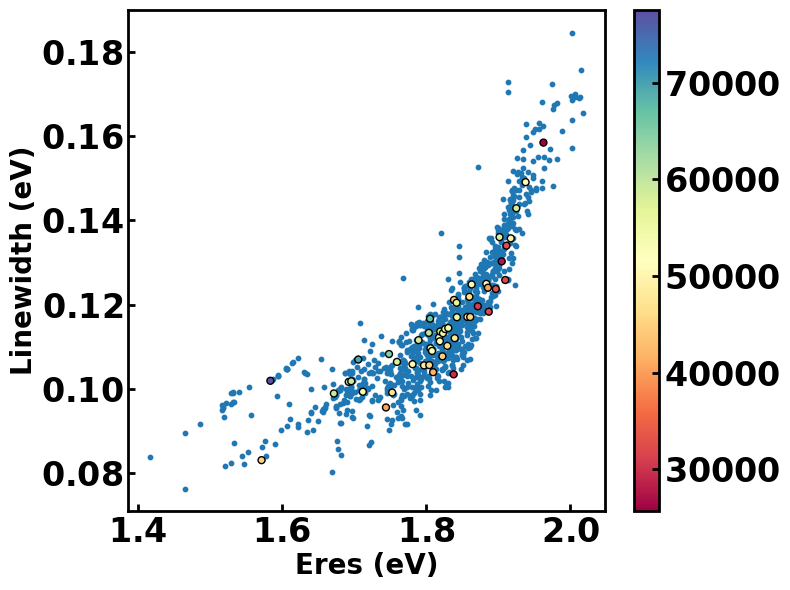

In [76]:
plt.scatter(glass_data['eres'], glass_data['linewidth'], s=10)
# plt.scatter(random_rows['eres'], random_rows['linewidth'], s=20)

plt.scatter(random_rows['eres'], random_rows['linewidth'], marker='o', s=25,  edgecolors='black', linewidth=1, c=random_rows['volume'], cmap='Spectral')
plt.colorbar()  # Add color bar indicating the scale
plt.xlabel('Eres (eV)')
plt.ylabel('Linewidth (eV)')

Text(0, 0.5, 'Volume')

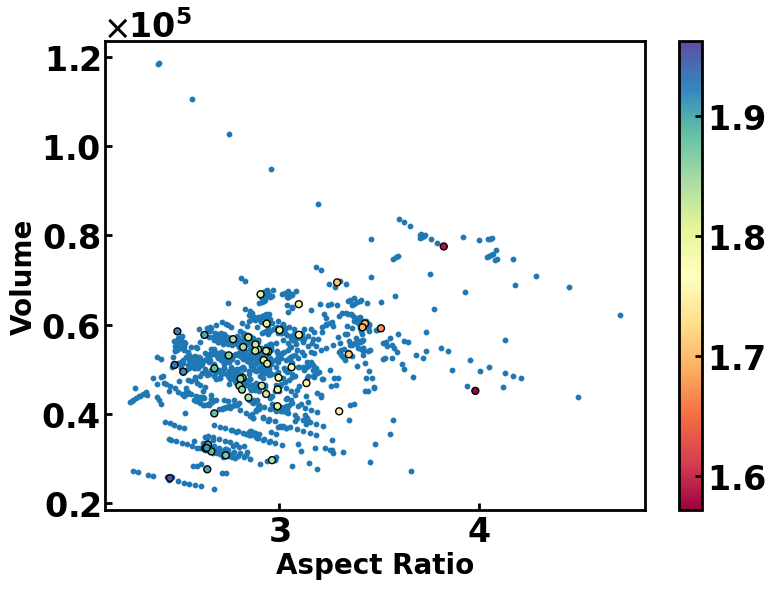

In [75]:
plt.scatter(glass_data['ratio'], glass_data['volume'], s=10)
# plt.scatter(random_rows['ratio'], random_rows['volume'], s=20)

plt.scatter(random_rows['ratio'], random_rows['volume'], marker='o', s=25, edgecolors='black', linewidth=1, c=random_rows['eres'], cmap='Spectral')
plt.colorbar()  # Add color bar indicating the scale
plt.xlabel('Aspect Ratio')
plt.ylabel('Volume')